In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier,ExtraTreesRegressor , RandomForestRegressor
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import pickle
from sklearn.neural_network import MLPClassifier

C:\Users\master\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\master\Anaconda3\lib\site-packages\dask\dataframe\utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\master\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
df = pd.read_csv('submission files/train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              2
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
df.dropna(subset=['Age'], inplace=True) # drop rows with missing ages 
df.drop(df[df['Age'] > 73].index, inplace = True)

In [5]:
def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))


    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('Variable quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

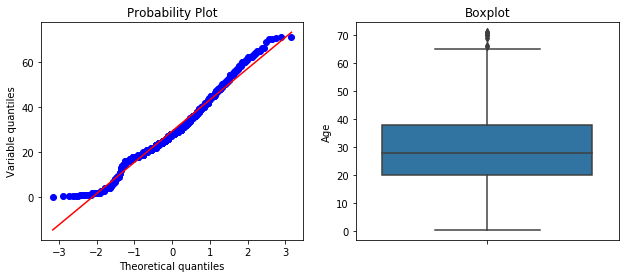

In [6]:
diagnostic_plots(df, 'Age')

In [7]:
def find_boundaries(df, variable):

    # the boundaries are the quantiles

    lower_boundary = df[variable].quantile(0.05)
    upper_boundary = df[variable].quantile(0.95)

    return upper_boundary, lower_boundary

In [8]:
Age_upper_limit, Age_lower_limit = find_boundaries(df, 'Age')
Age_upper_limit, Age_lower_limit

(55.0, 5.0)

In [9]:
df['Has_Cabin'] = df["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Has_Cabin
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


In [10]:
df.drop(columns= ['PassengerId', 'Name', 'Cabin', 'Ticket', 'Embarked'], inplace=True)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Has_Cabin
0,0,3,male,22.0,1,0,7.2500,0
1,1,1,female,38.0,1,0,71.2833,1
2,1,3,female,26.0,0,0,7.9250,0
3,1,1,female,35.0,1,0,53.1000,1
4,0,3,male,35.0,0,0,8.0500,0


In [11]:
y = df.iloc[:, 0].values
X = df.iloc[:,1:].values
X

array([[3, 'male', 22.0, ..., 0, 7.25, 0],
       [1, 'female', 38.0, ..., 0, 71.2833, 1],
       [3, 'female', 26.0, ..., 0, 7.925, 0],
       ...,
       [3, 'female', 7.0, ..., 2, 23.45, 0],
       [1, 'male', 26.0, ..., 0, 30.0, 1],
       [3, 'male', 32.0, ..., 0, 7.75, 0]], dtype=object)

In [12]:
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [1])], remainder='passthrough')
X = np.array(ct.fit_transform(X))
print(X)

[[0.0 1.0 3 ... 0 7.25 0]
 [1.0 0.0 1 ... 0 71.2833 1]
 [1.0 0.0 3 ... 0 7.925 0]
 ...
 [1.0 0.0 3 ... 2 23.45 0]
 [0.0 1.0 1 ... 0 30.0 1]
 [0.0 1.0 3 ... 0 7.75 0]]


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)
print(X_train)
print(X_test)
print(y_train)
print(y_test)

[[0.0 1.0 3 ... 1 29.125 0]
 [1.0 0.0 3 ... 0 7.925 0]
 [0.0 1.0 1 ... 0 91.0792 1]
 ...
 [0.0 1.0 3 ... 0 14.4542 0]
 [0.0 1.0 2 ... 0 26.0 0]
 [0.0 1.0 3 ... 0 8.05 0]]
[[0.0 1.0 3 ... 0 7.2292 0]
 [1.0 0.0 3 ... 0 7.8542 0]
 [0.0 1.0 3 ... 0 7.8542 0]
 ...
 [0.0 1.0 3 ... 2 27.9 0]
 [1.0 0.0 1 ... 1 211.3375 1]
 [0.0 1.0 3 ... 0 8.05 0]]
[0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 1 0 1 0 1 0 1 1 0 1 1 0 0 0 0
 0 1 0 1 1 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 0 1 1 0 0 1 0 1 0 1 0 0 1
 0 0 0 1 1 0 1 1 1 1 0 1 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 1 0
 1 1 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 1 0 1 1 0 0 1 1 0 1 0 1 0 0 0 0 1 1 0 1
 0 1 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 1 1 1 0 1 0 1 0 0 0 0 1 0 1 0 0 1 0
 1 0 0 1 0 0 1 0 1 1 0 0 0 0 0 0 1 0 1 1 1 1 0 0 1 0 1 0 1 1 0 0 0 0 1 1 1
 0 0 0 1 0 0 0 0 1 1 1 1 0 1 0 0 0 1 0 1 1 0 1 0 0 0 0 1 0 1 0 1 1 1 1 0 0
 1 1 0 0 0 0 1 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 1 0 0 0 1 0 1 0 0 0 0 1 0
 0 1 0 0 1 1 1 0 0 0 1 1 0 0 0 1 0 1 1 0 0 0 0 1 0 0 1 1 

In [14]:
sc = StandardScaler()
X_train[:, 2:] = sc.fit_transform(X_train[:, 2:])
X_test[:, 2:] = sc.transform(X_test[:, 2:])
print(X_train)
print(X_test)

[[0.0 1.0 0.8281714460249218 ... 0.8058835762047568 -0.03138211392011341
  -0.5398508867859422]
 [1.0 0.0 0.8281714460249218 ... -0.4838939757798315 -0.483923022789497
  -0.5398508867859422]
 [0.0 1.0 -1.5733563872334402 ... -0.4838939757798315 1.2911089226966586
  1.8523633552842642]
 ...
 [0.0 1.0 0.8281714460249218 ... -0.4838939757798315 -0.3445489613654414
  -0.5398508867859422]
 [0.0 1.0 -0.3725924706042592 ... -0.4838939757798315
  -0.09808920543977491 -0.5398508867859422]
 [0.0 1.0 0.8281714460249218 ... -0.4838939757798315 -0.4812547391287106
  -0.5398508867859422]]
[[0.0 1.0 0.8281714460249218 ... -0.4838939757798315 -0.4987757569588988
  -0.5398508867859422]
 [1.0 0.0 0.8281714460249218 ... -0.4838939757798315 -0.4854343386549665
  -0.5398508867859422]
 [0.0 1.0 0.8281714460249218 ... -0.4838939757798315 -0.4854343386549665
  -0.5398508867859422]
 ...
 [0.0 1.0 0.8281714460249218 ... 2.095661128189345 -0.057531293795820754
  -0.5398508867859422]
 [1.0 0.0 -1.5733563872334402

In [15]:
classifierlg = LogisticRegression(random_state = 1)
classifierlg.fit(X_train, y_train)

LogisticRegression(random_state=1)

In [16]:
y_pred = classifierlg.predict(X_test)
print(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[0.0 1.0 0.8281714460249218 ... -0.4838939757798315 -0.4987757569588988
  -0.5398508867859422]
 [1.0 0.0 0.8281714460249218 ... -0.4838939757798315 -0.4854343386549665
  -0.5398508867859422]
 [0.0 1.0 0.8281714460249218 ... -0.4838939757798315 -0.4854343386549665
  -0.5398508867859422]
 ...
 [0.0 1.0 0.8281714460249218 ... 2.095661128189345 -0.057531293795820754
  -0.5398508867859422]
 [1.0 0.0 -1.5733563872334402 ... 0.8058835762047568 3.8581749784083095
  1.8523633552842642]
 [0.0 1.0 0.8281714460249218 ... -0.4838939757798315 -0.4812547391287106
  -0.5398508867859422]]
[[0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [1 0]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [0 1]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [1 1]
 [0 1]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [0 0]


0.8426966292134831

In [17]:
filename = 'LogisticRegression_model842.sav'
pickle.dump(classifierlg, open(filename, 'wb'))

In [21]:
classifierknn = KNeighborsClassifier(n_neighbors = 5)
classifierknn.fit(X_train, y_train)

KNeighborsClassifier()

In [22]:
y_pred = classifierknn.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[91 19]
 [13 55]]


0.8202247191011236

In [24]:
model = MLPClassifier(hidden_layer_sizes=(32,16,1),
                      solver='adam', alpha= 0.001, learning_rate='adaptive',max_iter = 1000,
                      activation='relu')
model.fit(X_train,y_train)
predictions = model.predict(X_test)
cm = confusion_matrix(y_test, predictions)
print(cm)
accuracy_score(y_test, predictions)
print('Accuracy score ',accuracy_score(y_test,predictions))

[[86 24]
 [11 57]]
Accuracy score  0.8033707865168539


In [25]:
filename = 'MLPClassifier_model8426.sav'
pickle.dump(model, open(filename, 'wb'))

In [26]:
classifierdct = DecisionTreeClassifier(random_state = 0)
classifierdct.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [27]:
y_pred = classifierdct.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[89 21]
 [15 53]]


0.797752808988764

In [29]:
classifierf = RandomForestClassifier(n_estimators = 10, random_state = 1)
classifierf.fit(X_train, y_train)
y_pred = classifierf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[95 15]
 [14 54]]


0.8370786516853933

In [26]:
filename = 'RandomForestClassifier853.sav'
pickle.dump(classifierf, open(filename, 'wb'))

In [30]:
classifierxgb = XGBClassifier()
classifierxgb.fit(X_train, y_train)
y_pred = classifierxgb.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[1 0]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [1 0]
 [0 0]
 [1 1]
 [0 1]
 [1 1]
 [1 0]
 [0 1]
 [1 1]
 [0 1]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [1 1]
 [0 1]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [1 1]
 [0 1]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [1 1]
 [0 0]
 [1 1]
 [1 0]
 [0 0]
 [0 0]
 [1 1]
 [1 0]
 [0 0]
 [1 1]
 [0 1]
 [0 0]
 [0 0]
 [1 1]
 [1 0]
 [1 1]
 [0 0]
 [0 1]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [1 1]
 [0 0]
 [1 1]
 [0 0]
 [1 1]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [1 0]
 [0 0]
 [0 0]
 [1 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [1 1]
 [1 1]
 [0 0]
 [1 0]
 [0 0]
 [1 1]
 [1 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 0]
 [1 1]
 [0 0]
 [1 0]
 [0 0]
 [1 1]
 [0 0]
 [0 1]
 [1 1]
 [1 0]
 [0 0]
 [1 1]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 1]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 0]

0.8314606741573034